In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path

## Download train and test data

In [2]:
train_data = datasets.FashionMNIST(root='FashionMNIST_data',
                                   train=True,
                                   transform=ToTensor(),
                                   target_transform=None,
                                   download=True)

test_data = datasets.FashionMNIST(root='FashionMNIST_data',
                                  train=False,
                                  transform=ToTensor(),
                                  target_transform=None,
                                  download=True)

In [3]:
print(f"Length of train data : {len(train_data)}")
print(f"Length of test data : {len(test_data)}")

Length of train data : 60000
Length of test data : 10000


In [4]:
label_class = train_data.class_to_idx
label_class

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

## Train and Test dataloader

In [5]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=True)

In [6]:
train_dataloader.batch_size

32

In [7]:
len(train_dataloader)

1875

In [8]:
train_dataloader

In [9]:
next(iter(train_dataloader))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.2706, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

## visualize data

(-0.5, 27.5, 27.5, -0.5)

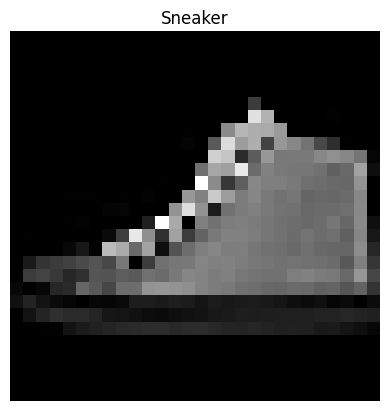

In [10]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
random_idx = torch.randint(low=0, high=len(train_feature_batch), size=[1]).item()
img, lbl = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(list(label_class.keys())[lbl])
plt.axis(False)

## Build model

In [11]:
class FashionMNISTModel(nn.Module):
    def __init__(self,
                 in_feature,
                 hidden_units,
                 out_fetures):
        super().__init__()
        self.linear_stack = nn.Sequential(nn.Flatten(),
                                          nn.Linear(in_features=in_feature, out_features=hidden_units),
                                          nn.ReLU(),
                                          nn.Linear(in_features=hidden_units, out_features=out_fetures),
                                          nn.ReLU()
                                          )

    def forward(self, X :torch.Tensor):
        return self.linear_stack(X)

In [12]:
model = FashionMNISTModel(in_feature=train_feature_batch.size()[1]*train_feature_batch.size()[2]*train_feature_batch.size()[3],
                          hidden_units=20,
                          out_fetures=10)

## Train/Test function

In [13]:
torch.manual_seed(42)

def train_model(model :torch.nn.Module,
                train_dataloader :DataLoader,
                loss_fn :nn.functional,
                acc_fn :nn.functional,
                optimizer :torch.optim):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in train_dataloader:
        train_logits = model(X)
        train_loss += loss_fn(train_logits, y)
        train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_acc += acc_fn(train_pred, y)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    return train_loss, train_acc*100


def eval_model(model :nn.Module,
               test_dataloader :DataLoader,
               loss_fn :nn.functional,
               acc_fn :nn.functional):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X,y in test_dataloader:
            test_logits = model(X)
            test_loss += loss_fn(test_logits, y)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc += acc_fn(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc*100

## Train/Test loop

In [14]:
torch.manual_seed(42)

# define accuracy function
acc_fn = Accuracy(task='multiclass',
                  num_classes=10)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.05)

epochs = 500
epoch_values = []
train_loss_values = []
test_loss_values = []

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_model(model,
                                        train_dataloader,
                                        loss_fn,
                                        acc_fn,
                                        optimizer)
    
    test_loss, test_acc = eval_model(model,
                                     test_dataloader,
                                     loss_fn,
                                     acc_fn)
    if epoch%50==0:
        print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Train_acc : {train_acc :.2f}% | Test_loss : {test_loss :.3f} | test_acc : {test_acc :.2f}%")
        epoch_values.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:02<18:31,  2.23s/it]

Epoch : 0 | Train_loss : 2.299 | Train_acc : 11.52% | Test_loss : 2.286 | test_acc : 11.76%


 10%|█         | 51/500 [01:55<17:06,  2.29s/it]

Epoch : 50 | Train_loss : 1.574 | Train_acc : 60.33% | Test_loss : 1.568 | test_acc : 60.34%


 20%|██        | 101/500 [03:49<15:04,  2.27s/it]

Epoch : 100 | Train_loss : 1.216 | Train_acc : 64.71% | Test_loss : 1.221 | test_acc : 64.23%


 30%|███       | 151/500 [05:43<13:15,  2.28s/it]

Epoch : 150 | Train_loss : 1.070 | Train_acc : 67.87% | Test_loss : 1.080 | test_acc : 67.36%


 40%|████      | 201/500 [07:37<11:19,  2.27s/it]

Epoch : 200 | Train_loss : 0.992 | Train_acc : 70.00% | Test_loss : 1.005 | test_acc : 69.31%


 50%|█████     | 251/500 [09:30<09:16,  2.23s/it]

Epoch : 250 | Train_loss : 0.788 | Train_acc : 74.09% | Test_loss : 0.798 | test_acc : 73.44%


 60%|██████    | 301/500 [11:22<07:19,  2.21s/it]

Epoch : 300 | Train_loss : 0.707 | Train_acc : 75.78% | Test_loss : 0.721 | test_acc : 74.69%


 70%|███████   | 351/500 [13:13<05:34,  2.24s/it]

Epoch : 350 | Train_loss : 0.667 | Train_acc : 77.06% | Test_loss : 0.682 | test_acc : 76.15%


 80%|████████  | 401/500 [15:05<03:42,  2.24s/it]

Epoch : 400 | Train_loss : 0.637 | Train_acc : 78.12% | Test_loss : 0.654 | test_acc : 77.21%


 90%|█████████ | 451/500 [16:56<01:49,  2.23s/it]

Epoch : 450 | Train_loss : 0.613 | Train_acc : 79.04% | Test_loss : 0.632 | test_acc : 77.96%


100%|██████████| 500/500 [18:46<00:00,  2.25s/it]


## Train/Test loss vs epochs

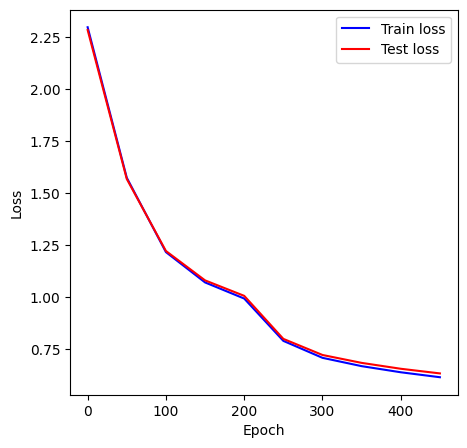

In [15]:
with torch.inference_mode():
    plt.figure(figsize=(5,5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_values, train_loss_values, c='b', label='Train loss')
    plt.plot(epoch_values, test_loss_values, c='r', label='Test loss')
    plt.legend()

## Make Prediction

In [16]:
torch.manual_seed(42)
def make_prediction(model :nn.Module,
                    data :torch.Tensor):
    with torch.inference_mode():
        logits = model(data)
        pred = torch.softmax(logits, dim=1).argmax(dim=1)
        return pred

In [17]:
test_pred = make_prediction(model,
                            test_data.data.type(torch.float))

test_pred == test_data.targets

tensor([ True,  True,  True,  ...,  True,  True, False])

## Plot confusion matrix

In [18]:
confusion_matrix = ConfusionMatrix(task='multiclass',
                                   num_classes=len(test_data.classes))
confusion_matrix_tensor = confusion_matrix(preds=test_pred,
                                           target=test_data.targets)
confusion_matrix_tensor

tensor([[812,   8,  13,  70,  12,   0,  59,   0,  25,   1],
        [  5, 932,  12,  39,   9,   0,   1,   0,   2,   0],
        [ 18,   2, 592,   7, 256,   0, 107,   0,  17,   1],
        [ 44,  17,  10, 832,  51,   0,  40,   0,   5,   1],
        [  0,   3,  79,  44, 808,   0,  57,   0,   8,   1],
        [  1,   0,   0,   2,   0, 518,   0, 234,  25, 220],
        [245,   3, 117,  42, 290,   0, 265,   0,  38,   0],
        [  0,   0,   0,   0,   0,   4,   0, 879,   1, 116],
        [  1,   2,   5,   8,   4,   0,  27,   6, 944,   3],
        [  0,   0,   0,   0,   0,   1,   0,  39,   2, 958]])

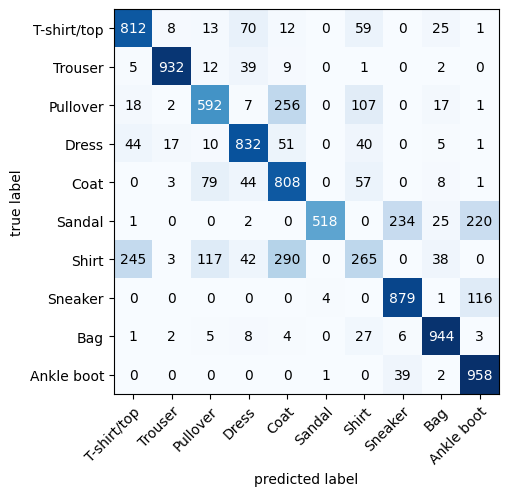

In [19]:
figure, axis = plot_confusion_matrix(
    confusion_matrix_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(5,5)
)

## Save model

In [20]:
model_path = Path('models')
model_path.mkdir(parents=True,
                 exist_ok=True)
torch.save(obj=model,
           f='/Users/navalmor/Desktop/PyTorch_Learning/computer vision/models/FashionMNISTModel.pt')